In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import cartopy.feature as cfeat
import cartopy.crs as ccrs
from math import pi, sin, radians
from scipy import integrate


Bad key "text.kerning_factor" on line 4 in
/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


#need to work on datetime conversion (should be 2001 not 2002, i think)

In [2]:
ds_bc = xr.open_dataset('concbc_Amon_MIROC-SPRINTARS_pdrmip-base_coupled_200101-210012.nc', decode_times=False)
ds_bcx10 = xr.open_dataset('concbc_Amon_MIROC-SPRINTARS_pdrmip-bcx10_coupled_200101-210012.nc', decode_times=False)
ds_bcx10 = ds_bcx10.rename_vars({'concbc':'concbcx10','ps':'psx10'})


In [3]:
ds_emibc = xr.open_dataset('emibc_Amon_MIROC-SPRINTARS_pdrmip-base_coupled_200101-210012.nc', decode_times=False)
ds_emibcx10 = xr.open_dataset('emibc_Amon_MIROC-SPRINTARS_pdrmip-bcx10_coupled_200101-210012.nc', decode_times=False)
ds_emibcx10 = ds_emibcx10.rename_vars({'emibc':'emibcx10'})


In [4]:
datasets = [ds_bcx10, ds_bc, ds_emibc, ds_emibcx10]

In [5]:
ds = xr.merge(datasets)

In [6]:
ds['time'] = pd.date_range("1/1/2001", "1/1/2101", freq = 'M')

In [7]:
s_to_month = 2.628e6
R=6371 #km

In [8]:
def find_area(R, lat1, lat2, lon1, lon2):
    A = np.abs((pi/180)*R**2 *(sin(radians(lat1))-sin(radians(lat2)))*(lon1-lon2))
    return(A)

In [ ]:
ds['area'] = xr.zeros_like(ds['ps'], dtype = np.float64)


for idx_lat in np.arange(0,len(ds['lat'])-1):
    for idx_lon in np.arange(0,len(ds['lon'])-1):
        A = find_area(R, ds.isel(lat = idx_lat)['lat'].values, ds.isel(lat = idx_lat+1)['lat'].values, 
                  ds.isel(lon = idx_lon)['lon'].values, ds.isel(lon = idx_lon+1)['lon'].values)
        lat1 = ds.isel(lat = idx_lat)['lat'].values
        lon1 = ds.isel(lon = idx_lon)['lon'].values
        ds['area'].loc[dict(lat = lat1, lon = lon1)] = A

In [ ]:
mid_dates = pd.date_range("1/31/2001", "11/30/2100", freq = 'M')+ pd.DateOffset(days=15)
ds_out = xr.Dataset(
    data_vars=dict(
        dc_dt=(["time"], np.zeros(len(mid_dates))),
        f=([ "time"], np.zeros(len(mid_dates))),
        G=(["time"], np.zeros(len(mid_dates)))
    ),
    coords=dict(
        time=mid_dates,
    ),
)

In [ ]:
def calc_f(ds, emis_species_0, emis_species_1, interp_dates):
    f = (
            (ds[emis_species_1]).weighted(ds['area']).mean(dim = ['lat','lon'])-
            (ds[emis_species_0]).weighted(ds['area']).mean(dim = ['lat','lon'])
        ).interp(time = interp_dates)
    return(f)
def calc_δc_δt(ds, conc_species_0, conc_species_1):
    ds['conc_dif'] = (ds[conc_species_1].sum('lev').weighted(ds['area']).mean(dim = ['lat','lon'])- ds[conc_species_0].weighted(ds['area']).mean(dim = ['lat','lon']).sum('lev'))
    δc_δt = ds['conc_dif'].diff('time')
    return(δc_δt)


In [ ]:
#calculate our forcing
ds_out['f'] = calc_f(ds, 'emibc','emibcx10', mid_dates)
#calculate our derivative
dcdt_vals = calc_δc_δt(ds, 'concbc','concbcx10').dropna(dim = 'time').values
ds_out['dcdt'] = xr.DataArray(data = dcdt_vals, dims = ['time'])
#calculate our green's function
ds_out['G'] = ds_out['dcdt']/ds_out['f']

In [ ]:
ds_out['G_annual'] = ds_out['dcdt'].groupby('time.year').mean()/ds_out['f'].groupby('time.year').mean()
ds_out['G_seasonal'] = ds_out['dcdt'].groupby('time.season').mean()/ds_out['f'].groupby('time.season').mean()
ds_out['G_monthly'] = ds_out['dcdt'].groupby('time.month').mean()/ds_out['f'].groupby('time.month').mean()

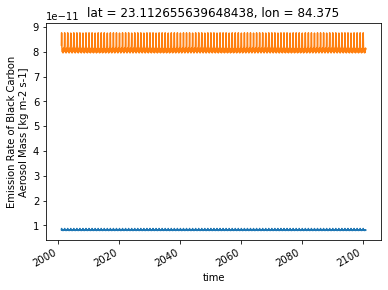

In [14]:
ds['emibc'].isel(lat = 80, lon = 60).rolling(time=1).mean().plot()
(ds['emibcx10'].isel(lat = 80, lon = 60).rolling(time=1).mean()).plot()
#plt.xlim('2001','2020')
#plt.ylim(0, 5e-9)

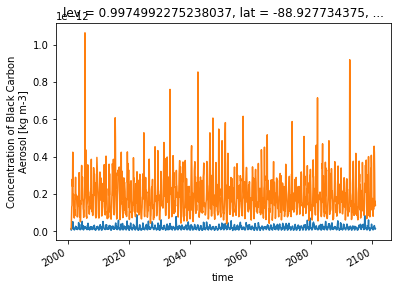

In [15]:
ds['concbc'].isel(lat = 0, lon = 60, lev=0).plot()
ds['concbcx10'].isel(lat = 0, lon = 60, lev=0).plot()
#plt.xlim('2001','2010')
#plt.ylim(0, 5e-8)

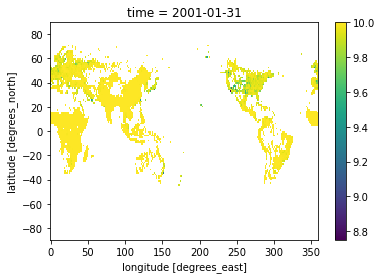

In [109]:
(ds['emibcx10']/ds['emibc']).isel(time = 0).where(ds['emibc'].isel(time = 0) > 1e-13).plot()

### Annual, global G

In [68]:
C_g = [sum((ds_out['G_annual'].isel(year = -tt)*ds_out['f'].groupby('time.year').mean().isel(year = slice(0,tt))).values) + 
     ds['concbc'].isel(time = 0).sum('lev').mean() 
     for tt in np.arange(0,len(np.unique(ds_out['time.year'])))]

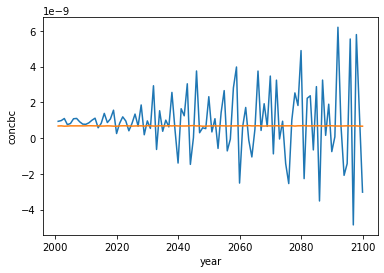

In [69]:
plt.plot(np.unique(ds_out['time.year']), C_g)
ds['concbc'].groupby('time.year').mean().sum(dim = 'lev').mean(dim = ['lat','lon']).plot()


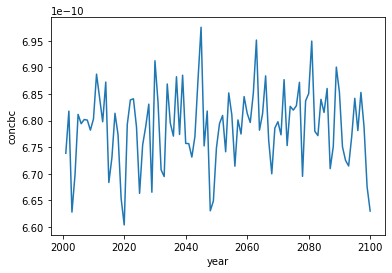

In [59]:
ds['concbc'].groupby('time.year').mean().sum(dim = 'lev').mean(dim = ['lat','lon']).plot()


### Monthly, global G

C_gm = [sum((ds_out['G_monthly'].isel(month = -tt)*ds_out['f'].groupby('time.month').mean().isel(month = slice(0,tt))).values) + 
     ds['concbc'].isel(time = 0).sum('lev').mean() 
     for tt in np.arange(0,len(np.unique(ds_out['time.month'])))]

In [134]:
C_gm = [sum((ds_out['G'].isel(time = slice(0,tt))*ds_out['f'].isel(time = slice(0,tt))).values) + 
     ds['concbc'].isel(time = 0).sum('lev').mean() 
     for tt in np.arange(0,len(np.unique(ds_out['time'])))]

In [94]:
[sum((ds_out['G'].isel(time = -tt)*ds_out['f'].isel(time = slice(0,tt))).values) + 
     ds['concbc'].isel(time = 0).sum('lev').mean() 
     for tt in np.arange(0,15)]

[<xarray.DataArray 'concbc' ()>
 array(9.34794575e-10)
 Coordinates:
     time     datetime64[ns] 2001-01-31,
 <xarray.DataArray 'concbc' ()>
 array(3.41281666e-09)
 Coordinates:
     time     datetime64[ns] 2001-01-31,
 <xarray.DataArray 'concbc' ()>
 array(2.00833778e-09)
 Coordinates:
     time     datetime64[ns] 2001-01-31,
 <xarray.DataArray 'concbc' ()>
 array(-1.60241436e-09)
 Coordinates:
     time     datetime64[ns] 2001-01-31,
 <xarray.DataArray 'concbc' ()>
 array(4.45891259e-10)
 Coordinates:
     time     datetime64[ns] 2001-01-31,
 <xarray.DataArray 'concbc' ()>
 array(6.1110795e-09)
 Coordinates:
     time     datetime64[ns] 2001-01-31,
 <xarray.DataArray 'concbc' ()>
 array(6.41119534e-09)
 Coordinates:
     time     datetime64[ns] 2001-01-31,
 <xarray.DataArray 'concbc' ()>
 array(8.4269987e-09)
 Coordinates:
     time     datetime64[ns] 2001-01-31,
 <xarray.DataArray 'concbc' ()>
 array(-2.82009765e-09)
 Coordinates:
     time     datetime64[ns] 2001-01-31,
 <xarray.D

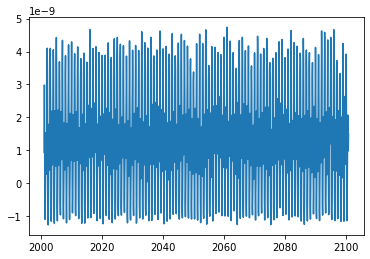

In [135]:
plt.plot(np.unique(ds_out['time']), C_gm)
#ds['concbc'].sum(dim = 'lev').mean(dim = ['lat','lon']).plot()
#plt.xlim(ds['time'][0],ds['time'][24])

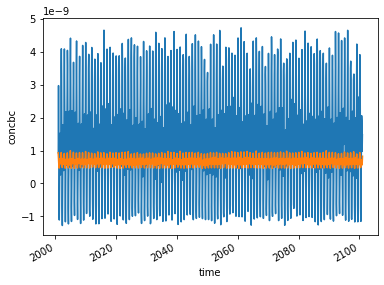

In [138]:
plt.plot(np.unique(ds_out['time']), C_gm)

(ds['concbc'].sum(dim = 'lev').mean(dim = ['lat','lon'])).plot()


da_dict = {}
for m in np.arange(1,13):
    da_dict[m] = (ds_out['f'].where(ds_out.time.dt.month == m)*ds_out['G_monthly'].sel(month = m)).dropna(dim = 'time')
    

In [76]:
da_monthly = xr.concat([da_dict[i] for i in np.arange(1,13)], dim = 'time').sortby('time')

In [77]:
int_Gm = integrate.cumulative_trapezoid(da_monthly, da_monthly, initial = 0)

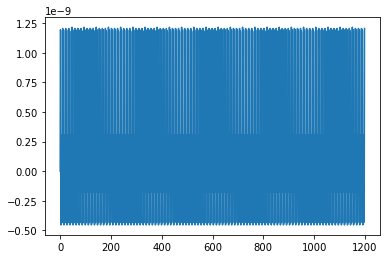

In [82]:
plt.plot(int_Gm*1e9)


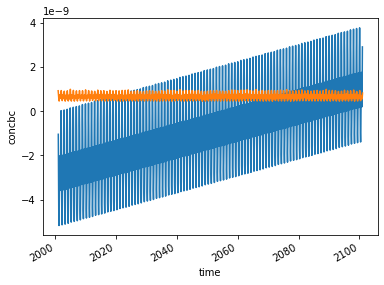

In [91]:
np.cumsum(da_monthly).plot()
ds['concbc'].sum(dim = 'lev').mean(dim = ['lat','lon']).plot()


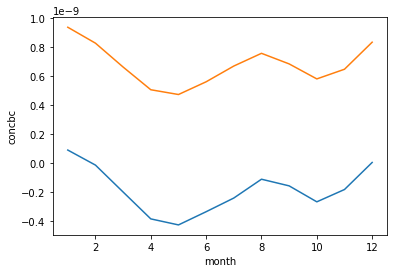

In [90]:
np.cumsum(ds_out['f'].groupby('time.month').mean()*ds_out['G_monthly']*1e-1).plot()
ds['concbc'].sum(dim = 'lev').mean(dim = ['lat','lon']).groupby('time.month').mean().plot()


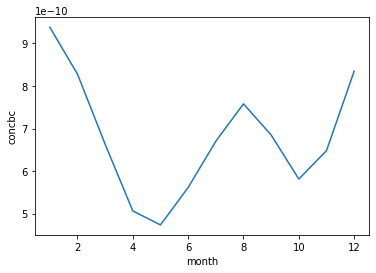

In [345]:
ds['concbc'].sum(dim = 'lev').mean(dim = ['lat','lon']).groupby('time.month').mean().plot()
#plt.xlim('2001-01-31T00:00:00.000000000','2002-01-31T00:00:00.000000000')

## Spatially Explicit

In [172]:
import regionmask

#### create a mask ####
states = regionmask.defined_regions.natural_earth.us_states_50
lon = np.arange(230, 300, .25)
lat = np.arange(50, 24, -.125)
mask = states.mask(ds, lon_name = 'lon', lat_name = 'lat')
contiguous_mask = ~np.isnan(mask) & (mask != 0.) & (mask != 11) 

#### mask our population dataset ####
US_ds = ds.where(contiguous_mask)


In [176]:
def calc_f(ds, emis_species_0, emis_species_1, interp_dates):
    f = (
            (ds[emis_species_1])-
            (ds[emis_species_0])
        ).interp(time = interp_dates)
    return(f)
def calc_δc_δt(ds, conc_species_0, conc_species_1):
    ds['conc_dif'] = (ds['concbc'].sum('lev')- ds['concbcx10'].sum('lev'))
    δc_δt = ds['conc_dif'].diff('time')
    return(δc_δt)


In [183]:
mid_dates = pd.date_range("1/31/2001", "11/30/2100", freq = 'M')+ pd.DateOffset(days=15)
ds_out = xr.Dataset(
    data_vars=dict(
        dcdt=(["time",'lat','lon'], np.zeros([len(mid_dates),len(ds['lat']), len(ds['lon'])])),
        f=([ "time",'lat','lon'], np.zeros([len(mid_dates),len(ds['lat']), len(ds['lon'])])),
        G=(["time",'lat','lon'], np.zeros([len(mid_dates),len(ds['lat']), len(ds['lon'])]))
    ),
    coords=dict(
        time=mid_dates,
        lat = ds['lat'],
        lon = ds['lon']
    ),
)

#calculate our forcing
ds_out['f'] = calc_f(US_ds, 'emibc','emibcx10', mid_dates)
#calculate our derivative
dcdt_vals = calc_δc_δt(US_ds, 'concbc','concbcx10').dropna(dim = 'time').values


In [184]:
ds_out['dcdt'] = xr.DataArray(data = dcdt_vals, dims = ['time','lat','lon'])
#calculate our green's function
ds_out['G'] = ds_out['dcdt']/ds_out['f']



ds_out['G'] = ds_out['G'].where(ds_out['G'] > -np.inf)
ds_out['G'] = ds_out['G'].where(ds_out['G'] < np.inf)

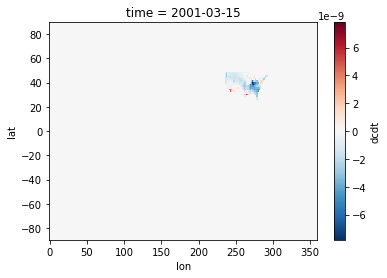

In [185]:
ds_out['dcdt'].isel(time = 1).plot()

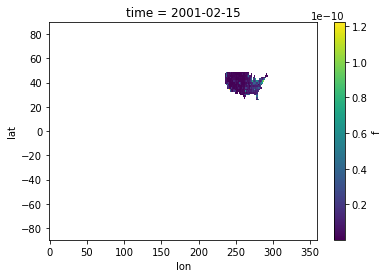

In [186]:
ds_out['f'].isel(time = 0).plot()

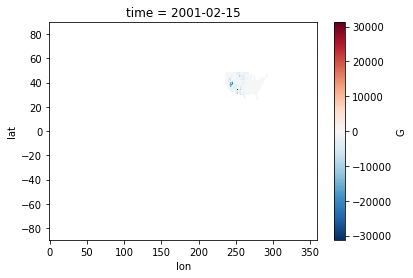

In [188]:
ds_out['G'].isel(time = 0).plot()

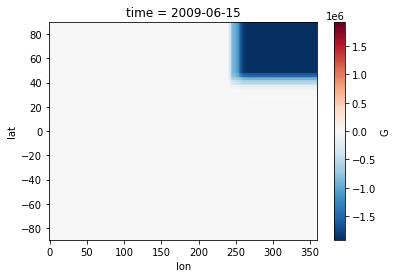

In [196]:
np.cumsum(ds_out['G']).isel(time = 100).plot()

In [191]:
ds_out['int_monthly'] = xr.DataArray(
    data=integrate.cumulative_trapezoid(ds_out['G'], ds_out['G'], initial = 0),
    dims=['time','lat','lon']
)

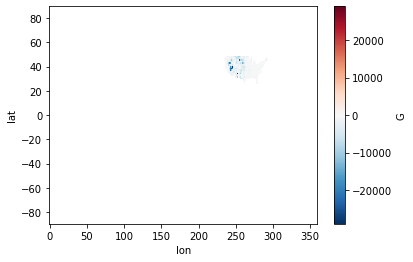

In [205]:
(ds_out['G'].isel(time = 0) + ds_out['G'].isel(time = 1)).plot()


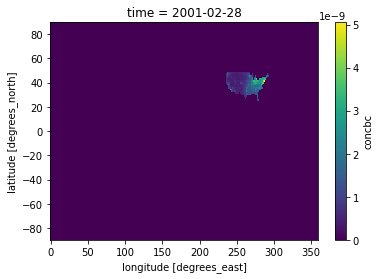

In [207]:
US_ds['concbc'].isel(time = 1).sum(dim = 'lev').plot()

In [ ]:
(ds_out['G'].isel(time = 0) + ds_out['G'].isel(time = 1) + ds_out['G'].isel(time = 2)).plot()